In [3]:
!git clone https://github.com/Bhuvanesh-Singla/CropAndWeed.git

Cloning into 'CropAndWeed'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 254 (delta 20), reused 25 (delta 7), pack-reused 197 (from 2)
Receiving objects: 100% (254/254), 71.28 MiB | 33.40 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [4]:
!pip install -r "/kaggle/working/CropAndWeed/Final Flow/requirements.txt"

INFO: pip is looking at multiple versions of torchmetrics to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is still looking at multiple versions of torchmetrics to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.p

In [8]:
%%writefile "/kaggle/working/CropAndWeed/Final Flow/pipeline.py"
import sys
import os

# Add ViTnanodet to sys.path so 'nanodet' submodule is importable
sys.path.append(os.path.join(os.path.dirname(__file__), 'nanodet_files', 'ViTnanodet'))

# Add VIT_files to sys.path so model.py is importable within vit_inference.py
sys.path.append(os.path.join(os.path.dirname(__file__), 'VIT_files'))


from VIT_files.vit_inference import WeedDetector
from nanodet_files.ViTnanodet.nanodet_inference import PlantDetector
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import argparse
import time

mappings = {
    'CROP': 0,
    'GRASSES': 1,
    'AMARANTH': 2,
    'GOOSEFOOT': 3,
    'KNOTWEED': 4,
    'CORN SPURRY': 5,
    'CHICKWEED': 6,
    'SOLANALES': 7,
    'POTATO WEED': 8,
    'CHAMOMILE': 9,
    'THISTLE': 10,
    'MERCURIES': 11,
    'GERANIUM': 12,
    'CRUCIFER': 13,
    'POPPY': 14,
    'PLANTAGO': 15,
    'LABIATE': 16
}



def batcher(bbox_predictions, vit_ids, image):
    transform = transforms.Compose([
        transforms.ToTensor(),                # Convert to tensor [C, H, W]
        # transforms.Permute([2, 0, 1]),        # Rearrange from [H, W, C] to [C, H, W]
        transforms.Resize((32,32)),        # Resize all images to 224x224
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
    ])
    transformed_patches = []
    for idx in vit_ids:
        detection = bbox_predictions[idx][1]
        x1, y1, x2, y2 = map(int,detection[:4])
        patch = image[y1:y2, x1:x2]
        transformed_patches.append(transform(patch))

    if len(transformed_patches) > 0:
        batch = torch.stack(transformed_patches)
    else:
        batch = None
    return batch

def annotate(image, final_predictions):
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.imshow(image)
    
    for idx, prediction in final_predictions.items():
        label, bbox = prediction.values()
        x_min, y_min, x_max, y_max = bbox
        
        # Convert to numeric values if they're lists
        if isinstance(x_min, list):
            x_min = x_min[0]
        if isinstance(y_min, list):
            y_min = y_min[0]
        if isinstance(x_max, list):
            x_max = x_max[0]
        if isinstance(y_max, list):
            y_max = y_max[0]
            
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle(
            (x_min, y_min), width, height, 
            linewidth=5, 
            edgecolor="red", 
            facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            x_min, y_min - 5, 
            label, 
            color="black", 
            fontsize=15, 
            bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 2}
        )
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    plt.tight_layout()
    # Convert the figure to a numpy array
    fig.canvas.draw()
    annotated_image = np.array(fig.canvas.renderer.buffer_rgba())
    
    # Close the figure to free memory
    plt.close(fig)
    
    return annotated_image

def crop_and_weed_pipeline(plant_detector,
                             weed_classifier,
                             image_path,
                             return_preds: bool = False):
    """
    Runs the crop-vs-weed detector and, for weeds, a 16-way species classifier.
    If return_preds=True, returns a list of (bbox, species_id) tuples and skips plotting.
    Otherwise, behaves exactly as before (annotates and shows/saves the image).
    """
    start = time.time()
    # Step 1: run detector
    meta, results = plant_detector.inference(image_path)
    image = meta["raw_img"][0].copy()

    # Gather raw detections
    bbox_predictions = {}
    idx_counter = 0
    for class_id, det_list in results.items():
        for det in det_list:
            bbox_predictions[idx_counter] = [class_id, det]
            idx_counter += 1

    # Step 2: filter by confidence & class
    vit_ids = []
    final_predictions = {}
    for idx, (cls, det) in bbox_predictions.items():
        if len(det) == 5 and det[4] >= 0.35:
            x1, y1, x2, y2, _ = det
            if cls == 0:
                # CROP
                final_predictions[idx] = {"label": "CROP",
                                          "bbox": [int(x1), int(y1), int(x2), int(y2)]}
            else:
                # WEED
                final_predictions[idx] = {"label": "WEED",
                                          "bbox": [int(x1), int(y1), int(x2), int(y2)]}
                vit_ids.append(idx)

    # Step 3: classify weed patches
    batch = batcher(bbox_predictions, vit_ids, image.copy())
    if batch is not None:
        species_preds = weed_classifier.predict(batch)
        for idx, sp in zip(vit_ids, species_preds):
            final_predictions[idx]["label"] += f"_{sp}"

    # Step 4: if only returning preds, skip annotation
    preds = []
    for info in final_predictions.values():
        lbl = info["label"]
        bbox = info["bbox"]
        if lbl.startswith("WEED_"):
            species_id = int(mappings[lbl.split("_")[1]])
            preds.append((bbox, species_id))
    if return_preds:
        return preds

    end = time.time()
    # --- existing annotation & display logic ---
    elapsed_time = end - start
    
    print("\n\n\n\ndone\n\n\n")
    print(f"Elapsed time: {elapsed_time:.2f} seconds")
    annotated_img = annotate(image.copy(), final_predictions)
    plt.imsave("/kaggle/working/annotated_image.jpg", annotated_img)
    print("saved to /kaggle/working/annotated_image.jpg")
    plt.figure(figsize=(12, 12))
    plt.imshow(annotated_img)
    plt.axis('off')
    plt.show()


if __name__ == "__main__":
    # # Paths to the model files
    # plant_detector_config_path = "nanodet_files/ViTnanodet/config/nanodet-plus-m_416-yolo-cpu.yml"
    # plant_detector_model_path = "nanodet_files/ViTnanodet/saved_models/nanodet_model_best.pth"
    # weed_classifier_model_path = "VIT_files/model_weights/vit_tiny.pth"
    # # Path to the image
    # image_path = "images/agri_0_1083.jpeg"
    #
    # Argument parser for command line arguments
    parser = argparse.ArgumentParser(description="Crop and Weed Detection Pipeline")
    parser.add_argument("--plant_detector_config", type=str, required=True, help="Path to the plant detector config file")
    parser.add_argument("--plant_detector_model", type=str, required=True, help="Path to the plant detector model file")
    parser.add_argument("--weed_classifier_model", type=str, required=True, help="Path to the weed classifier model file")
    parser.add_argument("--image_path", type=str, required=True, help="Path to the input image")
    args = parser.parse_args()    
    plant_detector_config_path = args.plant_detector_config
    plant_detector_model_path = args.plant_detector_model
    weed_classifier_model_path = args.weed_classifier_model
    image_path = args.image_path

    # Initialize the detectors
    plant_detector = PlantDetector(plant_detector_config_path, plant_detector_model_path)
    weed_classifier = WeedDetector(weed_classifier_model_path)


    # Run the pipeline
    crop_and_weed_pipeline(plant_detector, weed_classifier, image_path)
    # Example usage

Overwriting /kaggle/working/CropAndWeed/Final Flow/pipeline.py


In [6]:
import sys
sys.path.append("/kaggle/working/CropAndWeed/Final Flow")

In [9]:
!python "/kaggle/working/CropAndWeed/Final Flow/pipeline.py" --plant_detector_config "/kaggle/working/CropAndWeed/Final Flow/nanodet_files/ViTnanodet/config/nanodet-plus-m_416-yolo-cpu.yml" \
--plant_detector_model "/kaggle/working/CropAndWeed/Final Flow/nanodet_files/ViTnanodet/saved_models/nanodet_model_best.pth" \
--weed_classifier_model "/kaggle/working/CropAndWeed/Final Flow/VIT_files/vit_tiny.pth" \
--image_path "/kaggle/input/cleaned-cv-dataset/images/ave-0035-0006.jpg"


model size is  1.0x
init weights...
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████████████████████████████████| 8.79M/8.79M [00:00<00:00, 65.2MB/s]
=> loading pretrained model https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth
Finish initialize NanoDet-Plus Head.
/kaggle/working/CropAndWeed/Final Flow/VIT_files/vit_inference.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longe

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

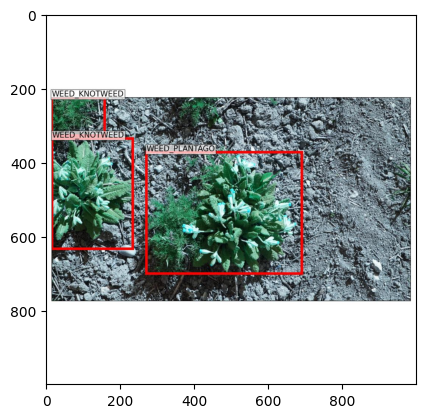

In [11]:
img = Image.open("/kaggle/working/annotated_image.jpg")
plt.imshow(img)